In [1]:
# これまでと構造体の中身が異なることに注意
class Models:
    def __init__(self,β:float,γ:float,rent:float,na:int,a_max:float,a_min:float,grid_a:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.na = na #貯蓄グリッドの数
        self.a_max = a_max # 貯蓄グリッドの最大値
        self.a_min = a_min # 貯蓄グリッドの最小値
        self.grid_a = grid_a # 貯蓄グリッド

In [2]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    na = 11
    a_max = 0.4
    a_min = 0.0

    grid_a = np.linspace(a_min,a_max,na)

    return Models(β, γ, rent, na, a_max, a_min, grid_a)

In [3]:
def mu_CRRA(cons,γ):
    return cons**(-γ)

In [4]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
# !pip install japanize_matplotlib
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
# from scipy import optimize # Python上の Optimization Tool
# import time # 計測時間をはかるためのパッケージ

## 内生的格子法


- 最適化や非線形方程式の根を探す方法は、最適化ライブラリを用いている。


- より複雑なモデルでは、最適化や非線形方程式の根を探すステップがボトルネックになる。


- 射影法の場合、ゼロ点を探すステップは1回限りであるが、多項式の次数を上げると、やはり係数を探す時間が大幅に増加する。

- Carroll(2006)による内生的格子法（Endogenous Gridpoint Method, EGM）は、オイラー方程式に基づきながら、グリッドの取り方を工夫する。


- EGMを使うことが出来るモデルであれば、繰り返し計算のステップを節約することで、計算速度を大幅にアップできる。

- これまでは、現在の所得が$w$である経済主体が生涯効用を最大にするためにはどの程度貯蓄$a$をすればよいか、という問題をダイレクトに解いていた。


- 一方、EGMでは状態変数である$w$ではなく操作変数である$a$を離散化して、状態変数については予算制約から逆算する。

- アルゴリズム

1. パラメータを設定する（カリブレーション）。

2. $a_{j} \in \{a_{1},\dots,a_{I}\}$を離散化した老年期の資産とする。

3. オイラー方程式の右辺を、
$$
  \Gamma(a_{j}) \equiv \beta (1+r) [(1+r)a_{j}]^{-\gamma}
$$
と定義する。$(\beta,\gamma,r)$はパラメータなので、$a_{j}$を一つ定めれば、上式は容易に計算できる。

4. オイラー方程式より$u'(c_{1})=\Gamma (a_{j})$である。限界効用関数の逆関数をとり、
$$
  c_{1} = \Gamma (a_{j})^{-\frac{1}{\gamma}}
$$
を計算することができる。

5. ステップ3-4を離散化したあらゆる$a_{j}$について計算すれば、ある$a_{j}$の下でオイラー方程式を満たす$c_{1,j}$、すなわち最適な消費$c_{1}$と貯蓄$a$の組み合わせを計算したことになる。予算制約は$c_{1,j}+a_{j}=w_{j}$なので、所得$w_{j}$の下での最適な消費と貯蓄の組み合わせが計算できたことになる。

In [5]:
def rhs_euler(a,params):

    # 老年期の限界効用
    mu = mu_CRRA((1.0+params.rent)*a, params.γ)

    # オイラー方程式の右辺
    return params.β*(1.0 + params.rent)*mu

In [6]:
def inv_mu_CRRA(mu,γ):
    return mu**(-1/γ)

In [7]:
params = Calibration()

rhs = np.zeros(params.na)
cons = np.zeros(params.na)

for i in range(params.na):
    rhs[i] = rhs_euler(params.grid_a[i], params)
    cons[i] = inv_mu_CRRA(rhs[i], params.γ)

w = np.zeros(params.na)
for i in range(params.na):
    w[i] = cons[i] + params.grid_a[i]

print(w)

[0.         0.11267324 0.22534648 0.33801972 0.45069295 0.56336619
 0.67603943 0.78871267 0.90138591 1.01405915 1.12673239]


C:\Users\takek\AppData\Local\Temp\ipykernel_25900\2903694489.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return cons**(-γ)


In [8]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*w

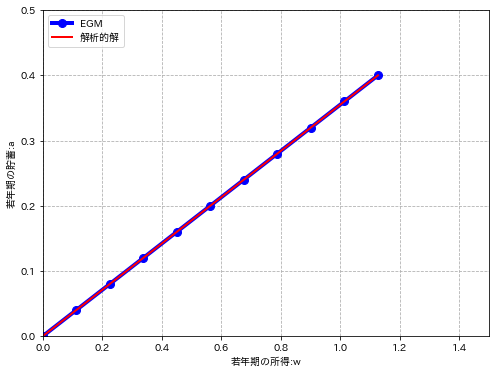

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(w,params.grid_a,c="b",marker="o",lw=4,ms=8,label="EGM")
ax.plot(w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.5),ylim=(0,0.5))
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()